# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
* Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fÃ©dÃ©rale-de-lausanne-epfl).Store the resulting dataset in a pandas DataFrame and answer the following questions:
  * Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

  * Answer the previous question aggregating the data by (c) country and (d) region.

  Plot your data using bar charts and describe briefly what you observed.

In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd 
import json 

import seaborn as sns

# set the default color palette
# try other options: 'Blues', sns.cubehelix_palette(8)
sns.set_palette('Blues')

# Seaborn can also use a context for different purpose
# possible values are paper, notebook, talk, and poster
sns.set_context("notebook")


import matplotlib.pyplot as plt
%matplotlib inline

import pickle

In [2]:
# get name, rank, country and region of the 200 first universities
url='https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508005996450'
universities= requests.get(url).json()['data'][:200]
df=pd.DataFrame(universities)
df = df.drop(['cc','core_id','guide', 'logo','score','stars','nid'], axis=1)

#list of urls to universities pages
urls =list(df['url'])

# function to get the rest of the needed information on each university page in a dictionnary
def get_details(url):
    university= requests.get('https://www.topuniversities.com' + url)
    soup= BeautifulSoup(university.text,'html.parser')
    data= soup.find_all('div', class_= 'faculty-main')
    df.head()

    # number of faculty members international
    if(soup.find_all('div', class_ = 'inter faculty') != []):
        inter_fac_mem = float(soup.find_all('div', class_ = 'inter faculty')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        inter_fac_mem = float('nan')
        
    # number of faculty members total
    if(soup.find_all('div', class_ = 'total faculty')!= []):
        total_fac_mem = float(soup.find_all('div', class_ = 'total faculty')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        total_fac_mem = float('nan')
        
    # number of students international
    if(soup.find_all('div', class_ = 'total inter')!= []):
        inter_student = float(soup.find_all('div', class_ = 'total inter')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        inter_student = float('nan')
        
    # number of students total
    if(soup.find_all('div', class_ = 'total student')!= []):
        total_student = float(soup.find_all('div', class_ = 'total student')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        total_student = float('nan')

    details = {'url' : url, '#faculty members international (QS)' : inter_fac_mem,
          '#faculty members total (QS)' : total_fac_mem,
          '#students international (QS)': inter_student,
          '#students total (QS)' : total_student}
    return details

#list of dictionnaries 
details = []    
for url in urls:
    details.append(get_details(url))
#convert to pd.DataFrame
df2 = pd.DataFrame(details)

#merge the two dataframes with the url
df_qs= pd.merge(df, df2, 'outer')
df_qs.rename(columns={'rank_display': 'QS rank', 'title': 'name'}, inplace=True)
df_qs = df_qs.drop('url', axis=1)

In [5]:
df_qs.head(12)

,country,QS rank,region,name,#faculty members international (QS),#faculty members total (QS),#students international (QS),#students total (QS)
0,United States,1,North America,Massachusetts Institute of Technology (MIT),1679.0,2982.0,3717.0,11067.0
1,United States,2,North America,Stanford University,2042.0,4285.0,3611.0,15878.0
2,United States,3,North America,Harvard University,1311.0,4350.0,5266.0,22429.0
3,United States,4,North America,California Institute of Technology (Caltech),350.0,953.0,647.0,2255.0
4,United Kingdom,5,Europe,University of Cambridge,2278.0,5490.0,6699.0,18770.0
5,United Kingdom,6,Europe,University of Oxford,2964.0,6750.0,7353.0,19720.0
6,United Kingdom,7,Europe,UCL (University College London),2554.0,6345.0,14854.0,31080.0
7,United Kingdom,8,Europe,Imperial College London,2071.0,3930.0,8746.0,16090.0
8,United States,9,North America,University of Chicago,635.0,2449.0,3379.0,13557.0
9,Switzerland,10,Europe,ETH Zurich - Swiss Federal Institute of Techno...,1886.0,2477.0,7563.0,19815.0


In [6]:
#USE PICKLE TO SAVE DF
#filename="./data/QS_ranking"
#df_qs.to_pickle(filename)

In [7]:
#USE PICKLE TO LOAD DF
#filename="./data/QS_ranking"
#df_qs =pd.read_pickle(filename)


In [8]:
df_qs['ratio between faculty members and students'] = df_qs['#faculty members total (QS)']/df_qs['#students total (QS)']
df_qs['ratio of international students'] = df_qs['#students international (QS)']/df_qs['#students total (QS)']

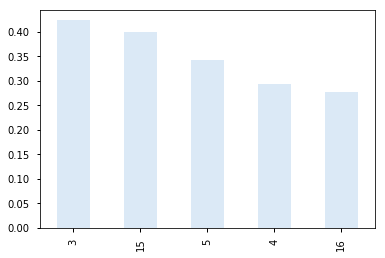

In [11]:
df_ratio1 = df_qs.sort_values('ratio between faculty members and students', ascending =False)
df_ratio1[['name', 'ratio between faculty members and students']].head()
df_ratio1[0:5]['ratio between faculty members and students'].plot.bar()


In [12]:
df_ratio2 = df_qs.sort_values('ratio of international students', ascending =False)
df_ratio2[['name', 'ratio of international students']].head()

,name,ratio of international students
34,London School of Economics and Political Scien...,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,Imperial College London,0.543567
198,Maastricht University,0.502533
47,Carnegie Mellon University,0.478062


In [13]:
 print(df_qs.groupby('country'))


* Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

* Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

* Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

* Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

In [ ]:

url='https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

json_dict= requests.get(url).json()
raw_data = pd.DataFrame(json_dict['data'])
raw_data.columns
data=raw_data[['name','rank','location','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio']]

data['rank']=data['rank'].str.extract('(\d+)').astype('int64')
data = data.loc[data['rank']<201]
data.rename(columns={'stats_number_students':'students','stats_pc_intl_students':'international students','stats_student_staff_ratio':'staff'},inplace=True)

data['students'] = data['students'].str.replace(',','').astype('int64')

data['international students'] = data['international students'].str.extract('(\d+)').astype('float64')
data['international students'] = (data['international students']/100)*data['students'].astype('float64')
data['international students'] = data['international students'].astype('int64')

data['staff'] = data['staff'].astype('float64')
data['staff'] = data['students'].astype('float64')/data['staff']
data['staff'] = data['staff'].astype('int64')


In [ ]:
data.head(10)